- Author: Peter Steiglechner
- Date: January 2025

> **The core idea**: Using data from the ESS about Germans' climate change opinions in 2016, 2021 and 2023 to estimate subjective actual and perceived opinion polarisation based on social identities. This notebook produces visualisations of the Exploratory Data Analysis:
> - showing the average of the German climate opinions by political identity
> - showing the opinion space as seen by a specific group through different lenses. Here for the example of the Greens perceiving 2021 opinion data from a 2016/17 point of view and from a 2021 point of view
> - printing counts of missing or removed data
> - printing the relative shares of each identity groups for each wave




In [1]:
from functions import *

from matplotlib.patches import Ellipse

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, norm

import matplotlib.colors as colors 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


sns.set_style("ticks", {"axes.linewidth":0.5})
smallfs = 7
bigfs = 9
plt.rc('font', family = 'sans-serif')
plt.rc('font', size=smallfs)          # Ticklabels, legend labels, etc.
plt.rc('axes', labelsize=bigfs)    # Axis labels
plt.rc('axes', titlesize=bigfs)    # Titles

# Load and prepare Data

In [2]:
wave_yrs = {8:"2016/17", 10:"2021", 11:"2023"}

prtcl_dict = {8: "prtclede", 10:"prtclfde", 11:"prtclgde"}

columns = ["essround", "anweight", "cntry"] + ["ccnthum", "wrclmch"] + ["prtdgcl"]+ list(prtcl_dict.values())

data = pd.read_csv(f"inputdata/ESS-subset.csv", usecols=columns)
print("size of original data")
data.essround.value_counts()

size of original data


essround
10    8725
8     2852
11    2420
Name: count, dtype: int64

In [ ]:
print("No answer on ccnthum or wrclmch")
for w in [8,10,11]:
    print(w, data.loc[(data.essround==w) & ((data.wrclmch>5.5) | (data.ccnthum>55)), "essround"].count())
print("ccnthum: climate not changing")
for w in [8,10,11]:
    print(w, data.loc[(data.essround==w) & ((data.ccnthum==55)), "ccnthum"].count())
print("removed due to other party & refuse partisan identity answer")
for w in [8,10,11]:
    print(w, data.loc[(data.essround==w) & ((data[prtcl_dict[w]].isin([7,8,9, 55]))), "essround"].count())
    print(w, data.loc[(data.essround==w) & ((data[prtcl_dict[w]].isin([77, 99]))), "essround"].count())
    #print(w, data.loc[(data.essround==w) & ((data[prtcl_dict[w]].isin([1,2,3,4,5,6])) & (data["prtdgcl"]==4)), "essround"].count())
print("non-partisan")
for w in [8,10,11]:
    print(w, data.loc[(data.essround==w) & ((data[prtcl_dict[w]].isin([66,88]))), "essround"].count())

No answer on ccnthum or wrclmch
8 60
10 277
11 14
ccnthum: climate not changing
8 3
10 85
11 4
removed due to other party & refuse partisan identity answer
8 59
8 55
10 177
10 498
11 41
11 70
non-partisan
8 1299
10 4036
11 1252


# Curate data

1. define partisan identities for each individual as the party that they feel closest to (and at least closer than "not at all close").
2. remove individuals with NaN values in the opinion data and the identity column
  

In [4]:
# 1. Identity
# 
party_dict = {
    1: "Union",
    2: "SPD",
    3: "Left Party",
    4: "Greens", 
    5: "FDP",
    6: "AfD"
}
for p in [7,8,9, 55, 77, 99]:
    party_dict[p] = np.nan  # individuals who feel close to other parties or refuse
for p in [66,88]:
    party_dict[p] = "None"   # individuals who do not feel close to any party.

for wave, prtcl in prtcl_dict.items():
    data.loc[data.essround==wave, "identity"] = data.loc[data.essround==wave][prtcl].replace(party_dict)
data.loc[(~data.identity.isna()) & (data.prtdgcl>3),"identity"] = "None"   # put individuals who feel "not at all close" to the stated party into non-partisan group

# 2. remove nan

variables_na = {"ccnthum": [55, 66, 77, 88, 99], "wrclmch": [6, 7, 8, 9]} 

for var, na_vals in variables_na.items():
    data[var] = data[var].replace(na_vals, np.nan)

# final dataset
    
data = data.dropna(subset=["identity"]+["ccnthum", "wrclmch"], how="any", axis="index")

In [5]:
cols = dict(zip(["Union", "SPD", "Left Party", "Greens", "FDP", "AfD", "None"], ["#000000", "#E3000F", "#b61c3e", "#1AA037", "#FFEF00", "#0489DB", "grey"]))  # 
kuerzel2party = {"u":"Union", "s":"SPD", "l":"Left Party", "g":"Greens", "f":"FDP", "a":"AfD", "n":"None"}
partiesOnly = ["Left Party", "Greens", "SPD", "FDP", "Union", "AfD"] 
parties = ["Left Party", "Greens", "SPD", "None", "FDP", "Union", "AfD"] 


### Relative sizes of identity groups

In [6]:
for wave in [8,10,11]:
    print(f"wave {wave}")
    print(((data.loc[data.essround==wave, "identity"].value_counts() / data.loc[data.essround==wave, "essround"].count()*100).round(1))[parties].to_dict())
    print("without None", ((data.loc[(data.essround==wave)&(data.identity!="None"), "identity"].value_counts() / (data.loc[(data.essround==wave)&(data.identity!="None"), "essround"].count())*100).round(1))[partiesOnly].to_dict())
print(data.essround.value_counts())

wave 8
{'Left Party': 5.6, 'Greens': 8.2, 'SPD': 14.6, 'None': 48.0, 'FDP': 1.9, 'Union': 18.1, 'AfD': 3.6}
without None {'Left Party': 10.8, 'Greens': 15.7, 'SPD': 28.1, 'FDP': 3.7, 'Union': 34.7, 'AfD': 7.0}
wave 10
{'Left Party': 4.0, 'Greens': 12.2, 'SPD': 12.4, 'None': 51.5, 'FDP': 5.1, 'Union': 12.7, 'AfD': 2.2}
without None {'Left Party': 8.3, 'Greens': 25.1, 'SPD': 25.5, 'FDP': 10.4, 'Union': 26.1, 'AfD': 4.6}
wave 11
{'Left Party': 2.5, 'Greens': 12.6, 'SPD': 10.1, 'None': 55.0, 'FDP': 2.3, 'Union': 13.2, 'AfD': 4.4}
without None {'Left Party': 5.5, 'Greens': 28.0, 'SPD': 22.4, 'FDP': 5.1, 'Union': 29.3, 'AfD': 9.7}
essround
10    7807
8     2681
11    2295
Name: count, dtype: int64


# Visualise original data (mean opinions)

In [7]:
questionLong = {
    "ccnthum":"Do you think climate change is caused by natural processes, human activity, or both?", 
    "wrclmch":"How worried are you about climate change?"
    }
questionLongBreak = {
    "ccnthum":"Do you think climate change\nis causedby natural processes,\nhuman activity, or both?", 
    "wrclmch":"How worried are you\nabout climate change?"
    }
question = {
    "ccnthum":"Climate change caused by natural \nprocesses, human activity, or both?", 
    "wrclmch":"How worried about\nclimate change?"
    }
replies = {
    "ccnthum": dict(zip(range(1,6), ["Entirely by natural processes", "Mainly by natural processes", "About equally by natural processes and human activity", "Mainly by human activity", "Entirely by human activity"])), 
    "wrclmch":dict(zip(range(1,6), ["Not at all worried", "Not very worried", "Somewhat worried", "Very worried", "Extremely worried"]))    
    # 55	I don't think climate change is happening 
}

repliesShort = {
    "ccnthum": dict(zip(range(1,6), ["natural", "mainly natural", "both", "mainly human", "human"])), 
    "wrclmch":dict(zip(range(1,6), ["not at all", "not very", "somewhat", "very", "extremely"]))    
    # 55	I don't think climate change is happening 
}
repliesShortVert = {
    "ccnthum": dict(zip(range(1,6), ["natural", "mainly\nnatural", "both", "mainly\nhuman", "human"])), 
    "wrclmch":dict(zip(range(1,6), ["not at all", "not very", "somewhat", "very", "extremely"]))    
    # 55	I don't think climate change is happening 
}

## Plot opinion averages (and errors) for climate attitudes

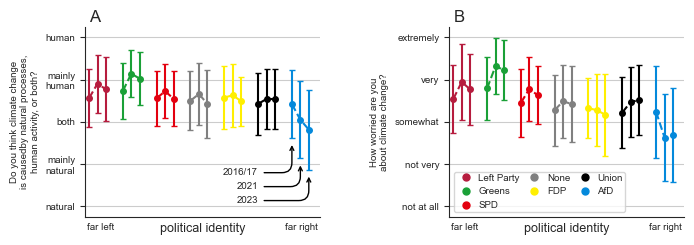

In [8]:
wrclmch_stats = data.groupby(['essround', "identity"])['wrclmch'].agg(['mean', 'std'])
ccnthum_stats = data.groupby(['essround', "identity"])['ccnthum'].agg(['mean', 'std'])

fig, axs = plt.subplot_mosaic([["c", "w"]], gridspec_kw={"wspace":0.55}, figsize=(17.8/2.54, 6/2.54))
for axname, stats, label in zip(axs, [ccnthum_stats, wrclmch_stats], ["ccnthum", "wrclmch"]):
    ax = axs[axname]
    wave_yrs = {8:"2016/17", 10:"2021", 11:"2023"}
    #stats = stats.reset_index()
    for n, p in enumerate(parties):
        p_stats = stats.loc[[(w, p) for w in wave_yrs.keys()]].reset_index()
        p_stats["yr"] = p_stats["essround"].replace(wave_yrs)
        col = cols[p]
        ax.errorbar(
            x=np.arange(4*n,4*n+len(p_stats["yr"])),
            y=p_stats['mean'],  
            yerr=p_stats['std'],  
            fmt="o--",
            markersize=4,
            capsize=2, 
            color=col,  
        )
        ax.plot([],[], "o", ms=5, color=col, label=p)
    ax.grid(axis="y")
    ax.set_ylim(0.75,5.25)
    ax.set_yticks(range(1,6))
    ax.set_yticklabels(list(repliesShortVert[label].values()))
    ax.set_ylabel(questionLongBreak[label], fontsize=smallfs)
    #ax.set_xticks(range(3))
    #ax.set_xticklabels(p_stats["yr"])
    ax.set_xlim(-0.5, )
    ax.set_xticks([])
    if ax==axs["c"]:
        arrowprops = dict(arrowstyle="->", color="k",connectionstyle="angle,angleA=0,angleB=-90,rad=10")
        for i,w in enumerate(wave_yrs.keys()):
            ax.annotate(wave_yrs[w], (4*n+i, p_stats.loc[i, "mean"]-p_stats.loc[i,"std"]-0.1), (4*n-4, 1.8-i*0.33), arrowprops=arrowprops, ha="right", va="center")

    ax.set_xlabel("political identity")
    ax.text(0.01, -0.03, "far left", va="top", ha="left", transform=ax.transAxes, fontsize=smallfs)
    ax.text(0.99, -0.03, "far right", va="top", ha="right", transform=ax.transAxes, fontsize=smallfs)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
axs["w"].legend(fontsize=smallfs, ncols=3, borderpad=0.2, columnspacing=0.5, handletextpad=0.3)
#fig.suptitle("Attitudes of German citizens towards climate change", fontsize=bigfs)

axs["c"].text(0.02, 1.01, "A", va="bottom", ha="left", fontdict={"weight":"normal", "size":12}, transform=axs["c"].transAxes)
axs["w"].text(0.02, 1.01, "B", va="bottom", ha="left", fontdict={"weight":"normal", "size":12}, transform=axs["w"].transAxes)

fig.subplots_adjust(right=0.98, top=0.915)
#fig.set_facecolor("y")
plt.savefig("figs/attitudes-means-by-group.pdf")
plt.savefig("figs/attitudes-means-by-group.png", dpi=600)

# perceived opinion space and lenses

In [9]:
inferSubjectiveLenses?

Signature: inferSubjectiveLenses(df, parties, waves, variables)
Docstring:
Extract the subjective lenses (matrices containing the scaled and rotated axes) for each partisan identity-group from opinion data in different waves.

Parameters:
    df (pd.DataFrame): Dataframe containing the columns "essround", "identity", and those listed in variables.
    parties (list): List containing the parties.
    waves (list): List of the waves (values in df.essround).
    variables (list): List of the opinion columns.

Returns:
    dict: a transofrmation matrix for each wave and party.
File:      ~/postdoc_csh/MS3/functions.py
Type:      function

In [10]:
Lenses = inferSubjectiveLenses(data, parties, waves=[8,10, 11], variables=["ccnthum", "wrclmch"])

### Example: Lenses 8 and 10 for Greens 

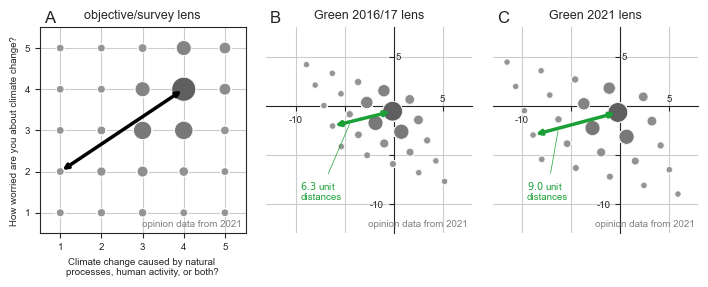

In [11]:
fig, axs = plt.subplots(1,3, figsize=(17.8/2.54, 7.2/2.54), gridspec_kw={"width_ratios":[1,1,1]})#, sharex=True, sharey=True)
p = "Greens"
cmapG = truncate_colormap(plt.get_cmap("Greys"), 0.5, 0.7)
titles = ["Green 2016/17 lens", "Green 2021 lens" ]
waves = [8,10]
r = waves[1]
for ax, LensesR, title in zip(axs[1:], [8,10] ,titles):
    Tr = Lenses[LensesR][p]
    MeanGreen = data.loc[data.essround==r].loc[data.identity=="Greens"][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy().mean(axis=0)
    df = data.loc[data.essround==r][["ccnthum", "wrclmch"]].dropna(how="any") - MeanGreen
    df = pd.DataFrame(np.dot(df, Tr), columns=["ax1", "ax2"])
    df['observation_count'] = df.groupby(['ax1', 'ax2']).transform('size')
    sns.scatterplot(
        x='ax1',
        y='ax2',
        hue='observation_count',
        palette=cmapG,  # Blues and oranges color palette
        size='observation_count',
        sizes=(20, 200),  # Adjust size range
        data=df,
        ax = ax, 
        legend=False, 
        zorder=10
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(-13, 8)
    ax.set_xlim(-13, 8)
    ax.set_xticks([-10, -5,0,5,])
    ax.set_yticks([-10,-5, 0, 5,])
    ax.set_xticklabels(["-10","", "",""])
    ax.set_yticklabels(["-10","","",""])
    ax.set_aspect("equal")
    ax.grid(True, zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.text(0.2,5, r"5", fontsize=smallfs, ha="left", va="center", )
    ax.text(5, 0.2, r"5", fontsize=smallfs, ha="center", va="bottom", )
    for sp in ax.spines:
        ax.spines[sp].set(zorder=1)
    ax.set_aspect("equal")


    # if slide==2:
    test1 = np.dot(np.array([4,4])-MeanGreen, Tr)
    test2 = np.dot(np.array([1,2])-MeanGreen, Tr)
    ax.annotate("", xy=test1, xytext=test2, arrowprops=dict(arrowstyle="<->", linewidth=2.5, color=cols[p]),zorder=15)

    testd = test2-test1
    d = np.linalg.norm(testd)
    angle = np.arctan(testd[1]/testd[0]) /np.pi*180
    testC = test1 + 0.7 * testd
    ax.annotate(rf"${d:.1f}$ unit"+"\n"+"distances", (testC[0], testC[1]), (-9.5, -7.5), va="top", ha="left", color=cols[p], fontsize=smallfs, 
    zorder=30, arrowprops=dict(arrowstyle= '-',color=cols[p],lw=0.5,ls='-'))
    
    ax.set_title(title, fontsize=bigfs)

    ax.text(0.98, 0.02, "opinion data from 2021", ha="right", va="bottom", color="grey", fontsize=smallfs, transform=ax.transAxes)
    
ax = axs[0]
cmap = truncate_colormap(plt.get_cmap("Greys"), 0.5, 0.7)
df =  data.loc[data.essround==r][["ccnthum", "wrclmch"]].dropna(how="any")
counts = df.groupby(['wrclmch', 'ccnthum']).size()
df['observation_count'] = df.groupby(['wrclmch', 'ccnthum']).transform('size')
sns.scatterplot(
    x='ccnthum',
    y='wrclmch',
    hue='observation_count',
    palette=cmap,  
    size='observation_count',
    sizes=(30, 300),  
    data=df,
    ax = ax, 
    legend=False
)
ax.set_ylim(0.5,5.5)
ax.set_xlim(0.5,5.5)
ax.set_xticks(range(1,6))
ax.set_yticks(range(1,6))
#if slide==2:
ax.annotate("", xy=np.array([4,4]), xytext=np.array([1,2]),arrowprops=dict(arrowstyle="<->", linewidth=2.5, color="k"),zorder=12)
ax.set_xticklabels(["1", "2", "3", "4", "5"], fontsize=smallfs)
ax.set_yticklabels(["1", "2", "3", "4", "5"], fontsize=smallfs)
ax.set_xlabel(question[ax.get_xlabel()], fontsize=smallfs)# x=0.1, ha="left")
ax.set_ylabel(questionLong[ax.get_ylabel()], fontsize=smallfs)#, y=0.1, ha="left")
ax.grid(True, zorder=0)
for sp in ax.spines:
    ax.spines[sp].set(zorder=1)
ax.set_aspect("equal")    
ax.set_title(r"objective/survey lens", fontsize=bigfs)#, ha="left", x=0)
ax.text(0.98, 0.02, "opinion data from 2021", ha="right", va="bottom", color="grey", fontsize=smallfs, transform=ax.transAxes)

letters = ["A", "B", "C", "D", "E", "F"]
for l, ax in enumerate(axs[:,].flatten()):
    ax.text(0.02, 1.01, letters[l], va="bottom", ha="left", fontdict={"weight":"normal", "size":12}, transform=ax.transAxes, zorder=20)


fig.subplots_adjust(left=0.05, right=0.99, top=0.98, bottom=0.12, wspace=0.1, hspace=0.1)
plt.savefig(f"figs/opinionDist2021_seen-by-greens_waves{waves[0]}{waves[1]}.pdf")
plt.savefig(f"figs/opinionDist2021_seen-by-greens_waves{waves[0]}{waves[1]}.png", dpi=600)

